In [18]:
import pandas as pd
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as Func

from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split

import pennylane as qml

import matplotlib.pyplot as plt
import h5py

In [2]:
data_transforms = transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

In [3]:
with h5py.File('Galaxy10_DECals.h5', 'r') as file:
    images = np.array(file['images'])
    classes = np.array(file['ans'])
    dec = np.array(file['dec'])
    pxscale = np.array(file['pxscale'])
    re = np.array(file['ra'])
    redshift = np.array(file['redshift'])
    print("Keys: %s" % file.keys())

#images, labels - галактики и их классы, dec, pxscale, re, redshift вряд ли пригодятся

Keys: <KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>


In [4]:
classes_names = { 
            0: "Disturbed Galaxy",
            1: "Merging Galaxy",
            2: "Round Smooth Galaxy",
            3: "In-between Round Smooth Galaxy",
            4: "Cigar Shaped Smooth Galaxy",
            5: "Barred Spiral Galaxy",
            6: "Unbarred Tight Spiral Galaxy",
            7: "Unbarred Loose Spiral Galaxy",
            8: "Edge-on Galaxy without Bulge",
            9: "Edge-on Galaxy with Bulge"
           }

#названия классов

In [5]:
classes_size = {
                0: 1081,
                1: 1853,
                2: 2645,
                3: 2027,
                4: 334,
                5: 2043,
                6: 1829,
                7: 2628,
                8: 1423,
                9: 1873
               }

(256, 256, 3)


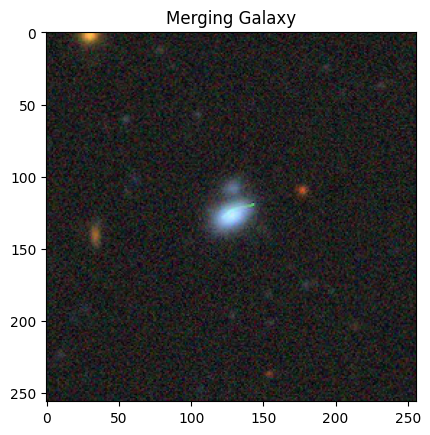

In [6]:
number = 1700
numpy_img = images[number]
plt.title(classes_names[classes[number]])
plt.imshow(numpy_img)
print(numpy_img.shape)
plt.show()

In [9]:
binary_classes_names = {
                    0: classes_names[2],
                    1: classes_names[9]
                 }

In [10]:
labels  = np.concatenate([np.zeros(5579 - 4934), np.ones(16536 - 15863)], axis=0) #перекодируем 2 в 0, 9 в 1
labels_ = np.zeros([1318, 2])

In [11]:
for i in range(1318):
    row = np.zeros(2)
    if labels[i] == 1:
        row[1] = 1
    else:
        row[0] = 1
    labels_[i] = row

In [12]:
labels_binary = torch.tensor(labels_, dtype=torch.float32)
images_binary = torch.tensor(np.concatenate([images[4934:5579], images[15863:16536]], axis=0), dtype=torch.float32)

In [13]:
images_binary = images_binary.reshape([1318, 3, 256, 256])

In [14]:
dataset = torch.utils.data.TensorDataset(images_binary, labels_binary)

In [15]:
train_set, test_set = train_test_split(dataset, test_size=0.1)

In [16]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [28]:
def train(model, train_loader, criterion, optimizer, losses, num_epochs=100):
    best_loss = 1000.0
    best_model = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        running_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            #print(images.dtype)
            output = model(images)
            #print(labels, output)
            loss = criterion(output, labels)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #scheduler.step()
        losses.append(running_loss)
        if (running_loss < best_loss):
            best_loss = running_loss
            best_model = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch + 1} / {num_epochs}")
    print('Training is finished')
    model.load_state_dict(best_model)
    return model

In [20]:
def predict(model, test_loader):
  n_samples = 0
  n_correct = 0
  n_class_samples = np.zeros(2)
  n_class_correct = np.zeros(2)
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      output = model(images)

    _, predictions = torch.max(output, -1)
    n_samples += labels.size(0)
    
    n_correct += sum([labels[k][int(predictions[k])] == 1.0 for k in range(batch_size)])
    
    for i in range(labels.shape[0]):
      label = labels[i]
      for k, elem in enumerate(label):
        if elem == 1.0:
          label_ = k
        #print(label_)
      pred = predictions[i]
      if (label_ == pred):
        n_class_correct[label_] += 1
      n_class_samples[label_] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(2):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {binary_classes_names[i]}: {acc} %')

In [21]:
# using pretrained resnet 18 with last layer fine tuning
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
losses = list()
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
lr_step = 3 * 10 ** -5
optimizer = optim.SGD(model.parameters(), lr=lr_step)
model = model.to(device)

In [63]:
model = train(model, train_loader, criterion, optimizer, losses, num_epochs=96)

Epoch 1 / 96
Epoch 2 / 96
Epoch 3 / 96
Epoch 4 / 96
Epoch 5 / 96
Epoch 6 / 96
Epoch 7 / 96
Epoch 8 / 96
Epoch 9 / 96
Epoch 10 / 96
Epoch 11 / 96
Epoch 12 / 96
Epoch 13 / 96
Epoch 14 / 96
Epoch 15 / 96
Epoch 16 / 96
Epoch 17 / 96
Epoch 18 / 96
Epoch 19 / 96
Epoch 20 / 96
Epoch 21 / 96
Epoch 22 / 96
Epoch 23 / 96
Epoch 24 / 96
Epoch 25 / 96
Epoch 26 / 96
Epoch 27 / 96
Epoch 28 / 96
Epoch 29 / 96
Epoch 30 / 96
Epoch 31 / 96
Epoch 32 / 96
Epoch 33 / 96
Epoch 34 / 96
Epoch 35 / 96
Epoch 36 / 96
Epoch 37 / 96
Epoch 38 / 96
Epoch 39 / 96
Epoch 40 / 96
Epoch 41 / 96
Epoch 42 / 96
Epoch 43 / 96
Epoch 44 / 96
Epoch 45 / 96
Epoch 46 / 96
Epoch 47 / 96
Epoch 48 / 96
Epoch 49 / 96
Epoch 50 / 96
Epoch 51 / 96
Epoch 52 / 96
Epoch 53 / 96
Epoch 54 / 96
Epoch 55 / 96
Epoch 56 / 96
Epoch 57 / 96
Epoch 58 / 96
Epoch 59 / 96
Epoch 60 / 96
Epoch 61 / 96
Epoch 62 / 96
Epoch 63 / 96
Epoch 64 / 96
Epoch 65 / 96
Epoch 66 / 96
Epoch 67 / 96
Epoch 68 / 96
Epoch 69 / 96
Epoch 70 / 96
Epoch 71 / 96
Epoch 72 / 96
E

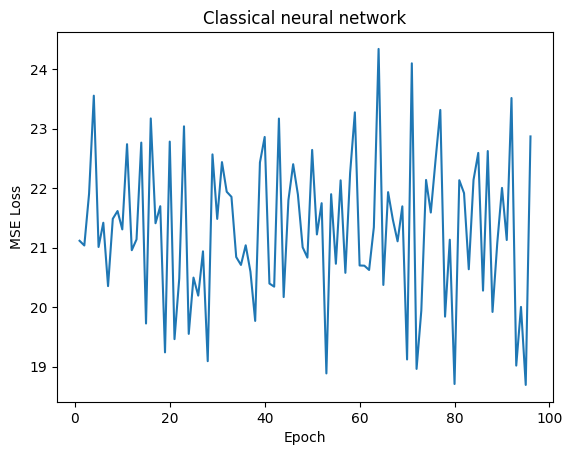

In [64]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, len(losses) + 1), losses)
plt.title("Classical neural network")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [65]:
predict(model, test_loader)

Accuracy of the network: 86.36363983154297 %
Accuracy of Round Smooth Galaxy: 84.84848484848484 %
Accuracy of Edge-on Galaxy with Bulge: 87.87878787878788 %
